In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy
import stft
from scipy.signal import blackman
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from time import perf_counter

In [2]:
%matplotlib inline

First, let's load some audio

In [3]:
rate, data = wavfile.read('01-18_Pulses.wav')

Next, we'll compute a spectrogram of a mono signal (obtained by summing the L & R channels) and using the default (cosine) window function

In [4]:
overlap = 4
framelength = 1024

specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=framelength, overlap=overlap)

We're interested in the absolute values of the spectrogram, and we'll log-scale it

In [5]:
log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
phase = np.angle(specgram)
print(log_spectrogram.shape)

(513, 56249)


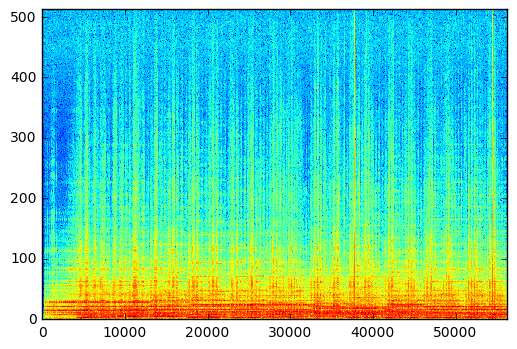

In [6]:
plt.imshow(log_spectrogram, origin='lower', aspect='auto',
           interpolation='nearest')

Now we'll specify for each moment of time `t` which preceding intervals of the form `[t-a,t-b]` we want to use for feature extraction. So if for each interval we have `N` different features, the total amount of different features we'll have is equal to `N * n_intervals`.

We want to have varied information from the audio, so we sample features not for every frame, but each `step_size` frames.

In [7]:
steps = [(-3000, 0), (-2000, 0), (-1000, 0), (-500, 0), (-250, 0), (-100, 0), (-50, 0), (-25, 0), (-6, 0)]
min_offset = max([-(i[0]) for i in steps])
step_size = 10

In [8]:
min_offset

3000

We want to have the frequency content of an interval as a (vector) feature; but we have too many frequency bins, so we just reduce their number by summation of their content.

In [9]:
freq_avg_step = 9
num_freq_bins_reduced = log_spectrogram.shape[0]//freq_avg_step
print(num_freq_bins_reduced)

57


Some feature extraction functions

In [13]:
def get_amplitude_change2(spgram_slice):
    # volume of second half - volume of first half
    a = np.sum(spgram_slice[:, :spgram_slice.shape[1]//2]) - np.sum(spgram_slice[:, spgram_slice.shape[1]//2:])
    return a / spgram_slice.shape[1]

In [14]:
def get_avg_amplitude(spgram_slice):
    return np.sum(spgram_slice) / spgram_slice.shape[1]  # get sum of amplitudes of the slice

In [15]:
def get_median_amplitude(spgram_slice):
    return np.median(spgram_slice)

In [16]:
def get_loudest_bin(spgram_slice):
    tmp = np.sum(spgram_slice, axis=1)
    return np.argmax(tmp)
# returns the index of the loudest frequency bin, the slice is averaged

Now we let's extract the features and the spectral content for each frame

In [22]:
feature_list = [get_avg_amplitude, get_loudest_bin, get_amplitude_change2, get_median_amplitude]

In [56]:
nfeat = len(feature_list) * len(steps) + num_freq_bins_reduced
# number of features - we have several scalar features for each slice of audio
# we also have the frequency bins (expanded) for previous frame

In [57]:
def get_features_for_frame(log_spgram_slice, scalar_functions, n_features):
    res = np.zeros(n_features)
    counter = 0
    for s_f in scalar_functions:
        for slicing in steps:
            res[counter] = s_f(log_spgram_slice[:, min_offset + slicing[0]:min_offset + slicing[1]])
            counter += 1
    for j in range(num_freq_bins_reduced):
        res[counter + j] = np.sum(log_spgram_slice[j * freq_avg_step:(j+1) * freq_avg_step, -1])
    return res

In [58]:
def process_spectrogram(log_spgram, scalar_functions, n_slices, n_features):
    # features, frequency content - X, Y
    # n_slices - the number of data points
    loc_Y = np.zeros([n_slices, log_spgram.shape[0]])
    loc_X = np.zeros([n_slices, n_features])
    for i in range(n_slices):
        if i%200 == 0:
            print(i)
        loc_Y[i] = log_spgram[:, min_offset + step_size * i]
        loc_X[i, 0:n_features] = get_features_for_frame(log_spgram[:,step_size * i:min_offset
                                                                     + step_size * i], scalar_functions, n_features)
    return [loc_X, loc_Y]

In [59]:
n_samples = 2500

start_time = perf_counter()
X, Y = process_spectrogram(log_spectrogram, feature_list,
                           n_samples, nfeat)
print(perf_counter() - start_time)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
128.03253224299988


Next, we scale the features and the target values

In [60]:
feature_scaler_freq = StandardScaler()
X = feature_scaler_freq.fit_transform(X)

freq_Y_mean = np.mean(Y)
freq_Y_std = np.std(Y)

Y = (Y - freq_Y_mean) / freq_Y_std

Then, we train a linear regression model

In [61]:
predictor = LinearRegression()
predictor.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's then try and generate some new audio (frequency and phase) and compare it with the real audio, to assess the performance of our model. First, we'll take a chunk of the audio that hasn't been fed to our model before, to use a starting point.
At some point, the model will only generate audio based on only newly generated audio.

In [133]:
keep_starting_audio = False  # if False, we cut off the seed audio
gen_start = min_offset + n_samples * step_size
print(gen_start, min_offset)  # the starting point of the seed audio and the length of the seed audio
generate_size = 5000  # how many samples we want to generate
result = np.zeros([log_spectrogram.shape[0], generate_size + min_offset])
result_phase = np.random.rand(log_spectrogram.shape[0], generate_size + min_offset) * 2 * 3.141
feat_arr = np.zeros([1, nfeat])

for i in range(min_offset):
    result[:, i] = log_spectrogram[:, gen_start + i]
max_val = np.max(np.sum(result**2, axis=0)) * 0.25  # to normalize the audio
start_time = perf_counter()
for i in range(generate_size):
    if i%500 == 0:
        print(i)
    feat_arr[0,:nfeat] = get_features_for_frame(result[:, i:i+min_offset],
                                                feature_list, nfeat)
    result[:, min_offset+i] = predictor.predict(feature_scaler_freq.transform(feat_arr))
    result[:, min_offset+i] *= freq_Y_std  # now we rescale it back
    result[:, min_offset+i] += freq_Y_mean
    if np.sum(result[:, min_offset+i]**2) > max_val:
        result[:, min_offset+i] /= max_val**0.5
print(perf_counter() - start_time)

28000 3000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
229.12910938600544


In [134]:
print(mean_squared_error(result[:, min_offset:],
                         log_spectrogram[:, gen_start + min_offset:gen_start + min_offset + generate_size]))

37.6227803729


In [135]:
result.shape

(513, 8000)

In [136]:
if not keep_starting_audio:
    result = result[:, min_offset:]
    result_phase = result_phase[:, min_offset:]

Let's now generate some audio based on an audio 'seed' (in this case, a chunk of the original waveform).
At some point, the model will only generate audio based on only newly generated audio.

In [143]:
np.max(np.sum(result**2, axis=0))

14196.166114351745

In [137]:
np.max(result), max_val

(30.050060644079498, 14196.393314243478)

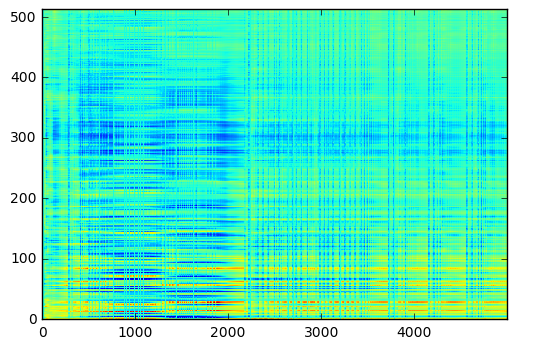

In [138]:
plt.imshow(result, origin='lower', aspect='auto',
           interpolation='nearest')

In [139]:
freq_amplitude = np.exp(result) - 1
result_complex = freq_amplitude * np.exp(1j * result_phase)

In [140]:
audio_dat = stft.ispectrogram(result_complex, framelength=framelength, overlap=overlap)

In [141]:
def write_stereo(a_l, a_r, s_r, name):
    a_s = np.zeros([a_l.shape[0], 2], dtype=np.int16)
    a_s[:, 0] = a_l
    a_s[:, 1] = a_r
    print(a_s.shape)
    wavfile.write(name, s_r, a_s)

In [142]:
write_stereo(audio_dat, audio_dat, 44100, 'reich-new_025_median.wav')

(1279744, 2)


In [ ]:
# Schoenberg – 3.5047782083
# Reich - 1.47755376083
# (-3000, 0), (-2000, 0), (-1000, 0), (-500, 0), (-250, 0), (-100, 0), (-50, 0), (-25, 0), (-6, 0)